In [2]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint
from stop_words import get_stop_words

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy for lemmatization
import spacy

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [3]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [4]:
df = pd.read_csv(os.path.join(os.getenv('SAVE_INTERIM_FILES_PATH'), 'agg_posts_text_translated.csv'), encoding='UTF-8')

In [170]:
df.head()

,client_id,post_id,Message Text,Published Date,Impressions,Likes,Shares,Comments,Engagements,Engagement Rate,class_weight,t Impressions,t Engagements,text,translated_text
0,40,df6561ff7e984e390c713f008c17b45e731e60d566421f...,"""I want to use high-quality films to get viewe...",2023-03-01,112773.0,996.0,20.0,427.0,1443.0,0.012796,0.014977,11.633132,7.274480,"""i want to use high-quality films to get viewe...","""i want to use high-quality films to get viewe..."
1,40,urn:li:share:6996161321742270465,"""For Bosch, digitalization presents major oppo...",2022-11-09,69.0,0.0,0.0,8.0,8.0,0.115942,0.014977,4.234107,2.079442,"""for bosch, digitalization presents major oppo...","""for bosch, digitalization presents major oppo..."
2,40,urn:li:share:6996419674615726080,From robots to connected mobility and smart ho...,2022-11-10,219.0,0.0,0.0,44.0,44.0,0.200913,0.014977,5.389072,3.784190,from robots to connected mobility and smart ho...,from robots to connected mobility and smart ho...
3,40,urn:li:share:6999324013894193152,"📖✨ Created by children for children: The new ""...",2022-11-18,116.0,0.0,0.0,1.0,1.0,0.008621,0.014977,4.753590,0.000000,"📖✨ created by children for children: the new ""...","📖✨ created by children for children: the new ""..."
4,40,urn:li:share:7000484386110324737,More than 70 % of the West African country Nig...,2022-11-21,136.0,2.0,0.0,3.0,5.0,0.036765,0.014977,4.912655,1.609438,more than 70 % of the west african country nig...,more than 70 % of the west african country nig...


In [5]:
# Convert to list
data = df.translated_text.values.tolist()
weights = df.class_weight.values.tolist()
post_ids = df.post_id.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove URLs from text
data = [re.sub(r'https?:\/\/.*[\r\n]*', '', sent, flags=re.IGNORECASE) for sent in data]

# Remove URN (LI identifiers) from text
data = [re.sub(r'\(urn:[\w\d\s].+\)', '', sent, flags=re.IGNORECASE) for sent in data]

# Remove odd hashtag structure provided by LI API
data = [re.sub(r'{[\w\s]+\|.*\|(.*?)}', '\1', sent) for sent in data]

# remove other odd API artifacts
data = [re.sub(r'\\\\\((.*?)\\\\\)', '\1', sent) for sent in data]
data = [re.sub(r'@\[(.*)\]', '\1', sent) for sent in data]

#data = [' '.join([word for word in sent.split() if word not in companies]) for sent in data]

# replace hashtags with nothing
data = [sent.replace('#', '') for sent in data]

In [6]:
# removing punctuations and unnecessary characters
# no max len for a token
# deacc=True removes punctuations
data_words = [simple_preprocess(str(text), deacc=True, min_len=2, max_len=100_000) for text in data]
pprint(data_words[:5])

[['want',
  'to',
  'use',
  'high',
  'quality',
  'films',
  'to',
  'get',
  'viewers',
  'fired',
  'up',
  'about',
  'snowboarding',
  'its',
  'incredible',
  'that',
  'such',
  'tiny',
  'sensor',
  'from',
  'bosch',
  'makes',
  'that',
  'possible',
  'says',
  'professional',
  'snowboarder',
  'and',
  'film',
  'producer',
  'yanneck',
  'konda',
  'built',
  'into',
  'the',
  'action',
  'camera',
  'yanneck',
  'uses',
  'for',
  'filming',
  'our',
  'image',
  'stabilization',
  'mems',
  'sensor',
  'measures',
  'just',
  'mm',
  'mm',
  'mm',
  'in',
  'size',
  'and',
  'contains',
  'parts',
  'that',
  'are',
  'finer',
  'than',
  'human',
  'hair',
  'despite',
  'its',
  'tiny',
  'size',
  'the',
  'sensor',
  'is',
  'packed',
  'with',
  'plenty',
  'of',
  'power',
  'to',
  'help',
  'the',
  'passionate',
  'snowboarder',
  'capture',
  'crisp',
  'and',
  'stable',
  'footage',
  'while',
  'moving',
  'at',
  'high',
  'speed',
  'on',
  'uneven',
 

In [7]:
# # Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# # Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# # See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['want',
 'to',
 'use',
 'high',
 'quality',
 'films',
 'to',
 'get',
 'viewers',
 'fired',
 'up',
 'about',
 'snowboarding',
 'its',
 'incredible',
 'that',
 'such',
 'tiny',
 'sensor',
 'from',
 'bosch',
 'makes',
 'that',
 'possible',
 'says',
 'professional',
 'snowboarder',
 'and',
 'film',
 'producer',
 'yanneck',
 'konda',
 'built',
 'into',
 'the',
 'action',
 'camera',
 'yanneck',
 'uses',
 'for',
 'filming',
 'our',
 'image',
 'stabilization',
 'mems',
 'sensor',
 'measures',
 'just',
 'mm',
 'mm',
 'mm',
 'in',
 'size',
 'and',
 'contains',
 'parts',
 'that',
 'are',
 'finer',
 'than',
 'human',
 'hair',
 'despite',
 'its',
 'tiny',
 'size',
 'the',
 'sensor',
 'is',
 'packed',
 'with',
 'plenty',
 'of',
 'power',
 'to',
 'help',
 'the',
 'passionate',
 'snowboarder',
 'capture',
 'crisp',
 'and',
 'stable',
 'footage',
 'while',
 'moving',
 'at',
 'high',
 'speed',
 'on',
 'uneven',
 'ground',
 'on',
 'top',
 'of',
 'that',
 'the',
 'sensor',
 'runs',
 'on',
 'exceptionally

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    # create English stop words list
    en_stop = get_stop_words('en')
    add_words_to_exc = ['https', 'hashtag']
    # filter possible company names from text
    companies = ['bosch', 'rexroth', 'schaeffler', 'koerber', 'symrise', 'dhl', 'dpdhl', 'barmer', 'nagra', 'boschrexroth', 'vdi']
    en_stop.extend(add_words_to_exc)
    en_stop.extend(companies)
    return [[word for word in doc if word not in en_stop] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

print(data_lemmatized[:1])

[['want', 'use', 'high', 'quality', 'film', 'get', 'viewer', 'fire', 'snowboard', 'incredible', 'tiny', 'sensor', 'make', 'possible', 'say', 'professional', 'snowboarder', 'film', 'producer', 'build', 'action', 'camera', 'use', 'film', 'image', 'stabilization', 'mem', 'sensor', 'measure', 'size', 'contain', 'part', 'fine', 'human', 'hair', 'tiny', 'size', 'sensor', 'pack', 'plenty', 'power', 'help', 'passionate', 'snowboarder', 'capture', 'stable', 'footage', 'move', 'high', 'speed', 'uneven', 'ground', 'top', 'sensor', 'run', 'low', 'power', 'help', 'preserve', 'camera', 'battery', 'low', 'temperature', 'learn']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Add weights to the corpus - HOW?
#for i, zipped in enumerate(zip(corpus, weights)):
#    doc, weight = zipped
#    doc.extend([(token_id, weight) for token_id, freq in doc])

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 4), (37, 2), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('battery', 1),
  ('build', 1),
  ('camera', 2),
  ('capture', 1),
  ('contain', 1),
  ('film', 3),
  ('fine', 1),
  ('fire', 1),
  ('footage', 1),
  ('get', 1),
  ('ground', 1),
  ('hair', 1),
  ('help', 2),
  ('high', 2),
  ('human', 1),
  ('image', 1),
  ('incredible', 1),
  ('learn', 1),
  ('low', 2),
  ('make', 1),
  ('measure', 1),
  ('mem', 1),
  ('move', 1),
  ('pack', 1),
  ('part', 1),
  ('passionate', 1),
  ('plenty', 1),
  ('possible', 1),
  ('power', 2),
  ('preserve', 1),
  ('producer', 1),
  ('professional', 1),
  ('quality', 1),
  ('run', 1),
  ('say', 1),
  ('sensor', 4),
  ('size', 2),
  ('snowboard', 1),
  ('snowboarder', 2),
  ('speed', 1),
  ('stabilization', 1),
  ('stable', 1),
  ('temperature', 1),
  ('tiny', 2),
  ('top', 1),
  ('uneven', 1),
  ('use', 2),
  ('viewer', 1),
  ('want', 1)]]

In [12]:
# Create a TF-IDF model from the corpus
tfidf_model = TfidfModel(corpus)

# Get the TF-IDF scores for each word in the dictionary
word_tfidf = {id2word[word_id]: value for word_id, value in tfidf_model.dfs.items()}

# Calculate the total number of words in the corpus
total_words = sum(word_tfidf.values())

# Define the threshold (30%) and (10%)
max_threshold_percentage = 30
min_threshold_percentage = 10
max_threshold_count = (max_threshold_percentage / 100) * total_words
min_threshold_count = (min_threshold_percentage / 100) * total_words

# Filter out words that exceed the threshold
filtered_words = [word for word, tfidf_score in word_tfidf.items() if min_threshold_count <= tfidf_score <= max_threshold_count]

In [13]:
# Build LDA model - probably good model with lambda 0.2 and num topics 4
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=12,
    random_state=100,
    update_every=1,
    chunksize=50,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)
   #chunksize=100,
   #passes=10,
   #alpha='auto',
   #per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.093*"healthy" + 0.082*"news" + 0.065*"picture" + 0.038*"sport" + '
  '0.029*"child" + 0.028*"passion" + 0.026*"encourage" + 0.024*"powerful" + '
  '0.024*"eat" + 0.019*"book"'),
 (1,
  '0.045*"solution" + 0.028*"system" + 0.025*"product" + 0.023*"use" + '
  '0.014*"high" + 0.014*"ensure" + 0.014*"range" + 0.014*"production" + '
  '0.014*"drive" + 0.012*"risk"'),
 (2,
  '0.099*"energy" + 0.029*"hydraulic" + 0.027*"design" + 0.026*"machine" + '
  '0.020*"movement" + 0.017*"consumption" + 0.017*"purpose" + 0.017*"unique" + '
  '0.017*"cost" + 0.016*"prevent"'),
 (3,
  '0.093*"repair" + 0.093*"service" + 0.052*"care" + 0.048*"order" + '
  '0.023*"choose" + 0.021*"course" + 0.020*"hand" + 0.020*"student" + '
  '0.018*"train" + 0.017*"maintenance"'),
 (4,
  '0.089*"day" + 0.033*"sustainability" + 0.031*"today" + 0.031*"year" + '
  '0.021*"environment" + 0.018*"live" + 0.016*"sustainable" + 0.015*"way" + '
  '0.015*"goal" + 0.014*"opportunity"'),
 (5,
  '0.092*"talk" + 0.088*"exciti

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.726995394855033

Coherence Score:  -6.9773945655409735


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.286977  0.002035       1        1  22.768631
11    -0.236318  0.186092       2        1  21.160563
1     -0.168870 -0.215021       3        1  14.861509
8     -0.166719 -0.069730       4        1  11.115782
4     -0.069511  0.208388       5        1   9.443324
2      0.029579 -0.235630       6        1   5.941888
7      0.109821  0.085797       7        1   4.142785
6      0.114208 -0.053372       8        1   3.693465
3      0.142841  0.042030       9        1   3.488848
9      0.178234  0.016789      10        1   1.445276
5      0.174092  0.018610      11        1   1.178274
0      0.179620  0.014012      12        1   0.759654, topic_info=             Term         Freq        Total Category  logprob  loglift
858           day  1174.000000  1174.000000  Default  30.0000  30.0000
758        energy   812.000000   812.000000  Default  29.0000  29.0000
510   information   520.000000   520.000000  Default  28.0000  28.0000
2687       repair   447.000000   447.000000  Default  27.0000  27.0000
915       service   446.000000   446.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
9635        false     0.062708     1.192816  Topic12  -9.7238   1.9345
4890      tractor     0.266782    31.242791  Topic12  -8.2758   0.1170
5444        music     0.266724    69.100874  Topic12  -8.2760  -0.6770
147     promotion     0.150284    14.054324  Topic12  -8.8497   0.3419
636   environment     0.155977   278.033915  Topic12  -8.8125  -2.6057

[509 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1429      2  0.997103          able
5945     12  0.678856      academic
774       1  0.993475        access
0         2  0.150992        action
0         3  0.835487        action
...     ...       ...           ...
163       4  0.007725          year
163       5  0.446936          year
163       7  0.026485          year
1582      3  0.987079     yesterday
165      12  0.932130  young_people

[687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 2, 9, 5, 3, 8, 7, 4, 10, 6, 1])

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, coh_metric='u_mass', start=2, step=3):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus, 
            num_topics=num_topics, 
            id2word=id2word,
            random_state=100,
            update_every=1,
            chunksize=50,
            alpha='auto',
            eta='auto',
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coh_metric)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
start=2; limit=20; step=1;
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, coh_metric='u_mass', start=start, limit=limit, step=step)

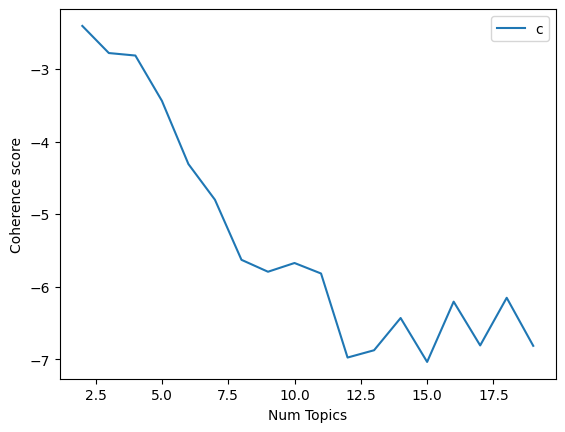

In [19]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -2.4056
Num Topics = 3  has Coherence Value of -2.7796
Num Topics = 4  has Coherence Value of -2.8139
Num Topics = 5  has Coherence Value of -3.438
Num Topics = 6  has Coherence Value of -4.3101
Num Topics = 7  has Coherence Value of -4.8021
Num Topics = 8  has Coherence Value of -5.6302
Num Topics = 9  has Coherence Value of -5.7945
Num Topics = 10  has Coherence Value of -5.674
Num Topics = 11  has Coherence Value of -5.8187
Num Topics = 12  has Coherence Value of -6.9774
Num Topics = 13  has Coherence Value of -6.8767
Num Topics = 14  has Coherence Value of -6.4324
Num Topics = 15  has Coherence Value of -7.0378
Num Topics = 16  has Coherence Value of -6.2068
Num Topics = 17  has Coherence Value of -6.8106
Num Topics = 18  has Coherence Value of -6.1536
Num Topics = 19  has Coherence Value of -6.8159


In [23]:
# Select the model and print the topics
optimal_model = model_list[10]#[coherence_values.index(min(coherence_values))]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.093*"healthy" + 0.082*"news" + 0.065*"picture" + 0.038*"sport" + '
  '0.029*"child" + 0.028*"passion" + 0.026*"encourage" + 0.024*"powerful" + '
  '0.024*"eat" + 0.019*"book"'),
 (1,
  '0.045*"solution" + 0.028*"system" + 0.025*"product" + 0.023*"use" + '
  '0.014*"high" + 0.014*"ensure" + 0.014*"range" + 0.014*"production" + '
  '0.014*"drive" + 0.012*"risk"'),
 (2,
  '0.099*"energy" + 0.029*"hydraulic" + 0.027*"design" + 0.026*"machine" + '
  '0.020*"movement" + 0.017*"consumption" + 0.017*"purpose" + 0.017*"unique" + '
  '0.017*"cost" + 0.016*"prevent"'),
 (3,
  '0.093*"repair" + 0.093*"service" + 0.052*"care" + 0.048*"order" + '
  '0.023*"choose" + 0.021*"course" + 0.020*"hand" + 0.020*"student" + '
  '0.018*"train" + 0.017*"maintenance"'),
 (4,
  '0.089*"day" + 0.033*"sustainability" + 0.031*"today" + 0.031*"year" + '
  '0.021*"environment" + 0.018*"live" + 0.016*"sustainable" + 0.015*"way" + '
  '0.015*"goal" + 0.014*"opportunity"'),
 (5,
  '0.092*"talk" + 0.088*"exciti

In [78]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame(columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ",".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,4), topic_keywords]
                #sent_topics_df = sent_topics_df.append(pd.Series(), ignore_index=True)
            else:
                break
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.4171,"solution,system,product,use,high,ensure,range,...","""i want to use high-quality films to get viewe..."
1,1,4,0.2932,"day,sustainability,today,year,environment,live...","""for bosch, digitalization presents major oppo..."
2,2,8,0.4752,"customer,automation,opportunity,industry,digit...",from robots to connected mobility and smart ho...
3,3,11,0.2617,"work,team,people,company,program,employee,coll...","📖✨ created by children for children: the new ""..."
4,4,4,0.2500,"day,sustainability,today,year,environment,live...",more than 70 % of the west african country nig...
5,5,11,0.3534,"work,team,people,company,program,employee,coll...",🅿️🚘 imagine parking in a garage without the ha...
6,6,11,0.3443,"work,team,people,company,program,employee,coll...","👶 from a crib, to a nursing table, to a desk: ..."
7,7,7,0.1932,"information,visit,lot,happy,award,register,ctr...","✨❄️ are you already relaxing in your ""ugly swe..."
8,8,10,0.3317,"health,future,find,new,see,part,learn,project,...","have you heard of blockchains, cryptocurrency ..."
9,9,11,0.2140,"work,team,people,company,program,employee,coll...",starting the year 2023 with personnel changes:...


In [80]:
# to the top topics add the own words from the text
document_topics = []
topics_assigned = df_dominant_topic["Dominant_Topic"].values.tolist()
zipped = zip(corpus, topics_assigned)
for corpus_doc, dest_topic in zipped:
    words = []
    for word_id, count in corpus_doc:
        word = lda_model.id2word[word_id]
        topics = optimal_model.get_term_topics(word_id)
        topics = list(filter(lambda t: t[0] == topic_dest, topics))
        if len(topics):
            words.append(word)
    if len(words):        
        document_topics.append(','.join(words[:5]))
    else:
        document_topics.append('')

keywords_list = df_dominant_topic["Keywords"].values.tolist()
keywords_result = []
for i, j in zip(keywords_list, document_topics):
    keywords_result.append(','.join(set(i.split(',') + j.split(','))))

df_dominant_topic["Keywords"] = keywords_result
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.4171,"system,risk,product,use,production,range,high,...","""i want to use high-quality films to get viewe..."
1,1,4,0.2932,"today,year,sustainability,live,goal,digitaliza...","""for bosch, digitalization presents major oppo..."
2,2,8,0.4752,"partner,factory,read,customer,topic,digital,au...",from robots to connected mobility and smart ho...
3,3,11,0.2617,",year,work,make,colleague,people,employee,supp...","📖✨ created by children for children: the new ""..."
4,4,4,0.2500,",today,year,sustainability,live,goal,way,envir...",more than 70 % of the west african country nig...
5,5,11,0.3534,"technology,year,work,make,colleague,people,emp...",🅿️🚘 imagine parking in a garage without the ha...
6,6,11,0.3443,"technology,year,work,make,colleague,people,emp...","👶 from a crib, to a nursing table, to a desk: ..."
7,7,7,0.1932,"visit,transport,happy,ctrlx_automation,registe...","✨❄️ are you already relaxing in your ""ugly swe..."
8,8,10,0.3317,"technology,learn,great,new,future,part,health,...","have you heard of blockchains, cryptocurrency ..."
9,9,11,0.2140,"technology,year,work,make,colleague,people,emp...",starting the year 2023 with personnel changes:...


In [86]:
df_dominant_topic["post_id"] = post_ids
result = pd.merge(df, df_dominant_topic.loc[:, ["post_id", "Dominant_Topic", "Keywords"]], on = 'post_id', how = 'inner')
result.drop(columns=["translated_text"])
result.to_csv(os.path.join(os.getenv('SAVE_INTERIM_FILES_PATH'), 'agg_posts_lda_merged_results_with_keywords.csv'), index=False, encoding='UTF-8')

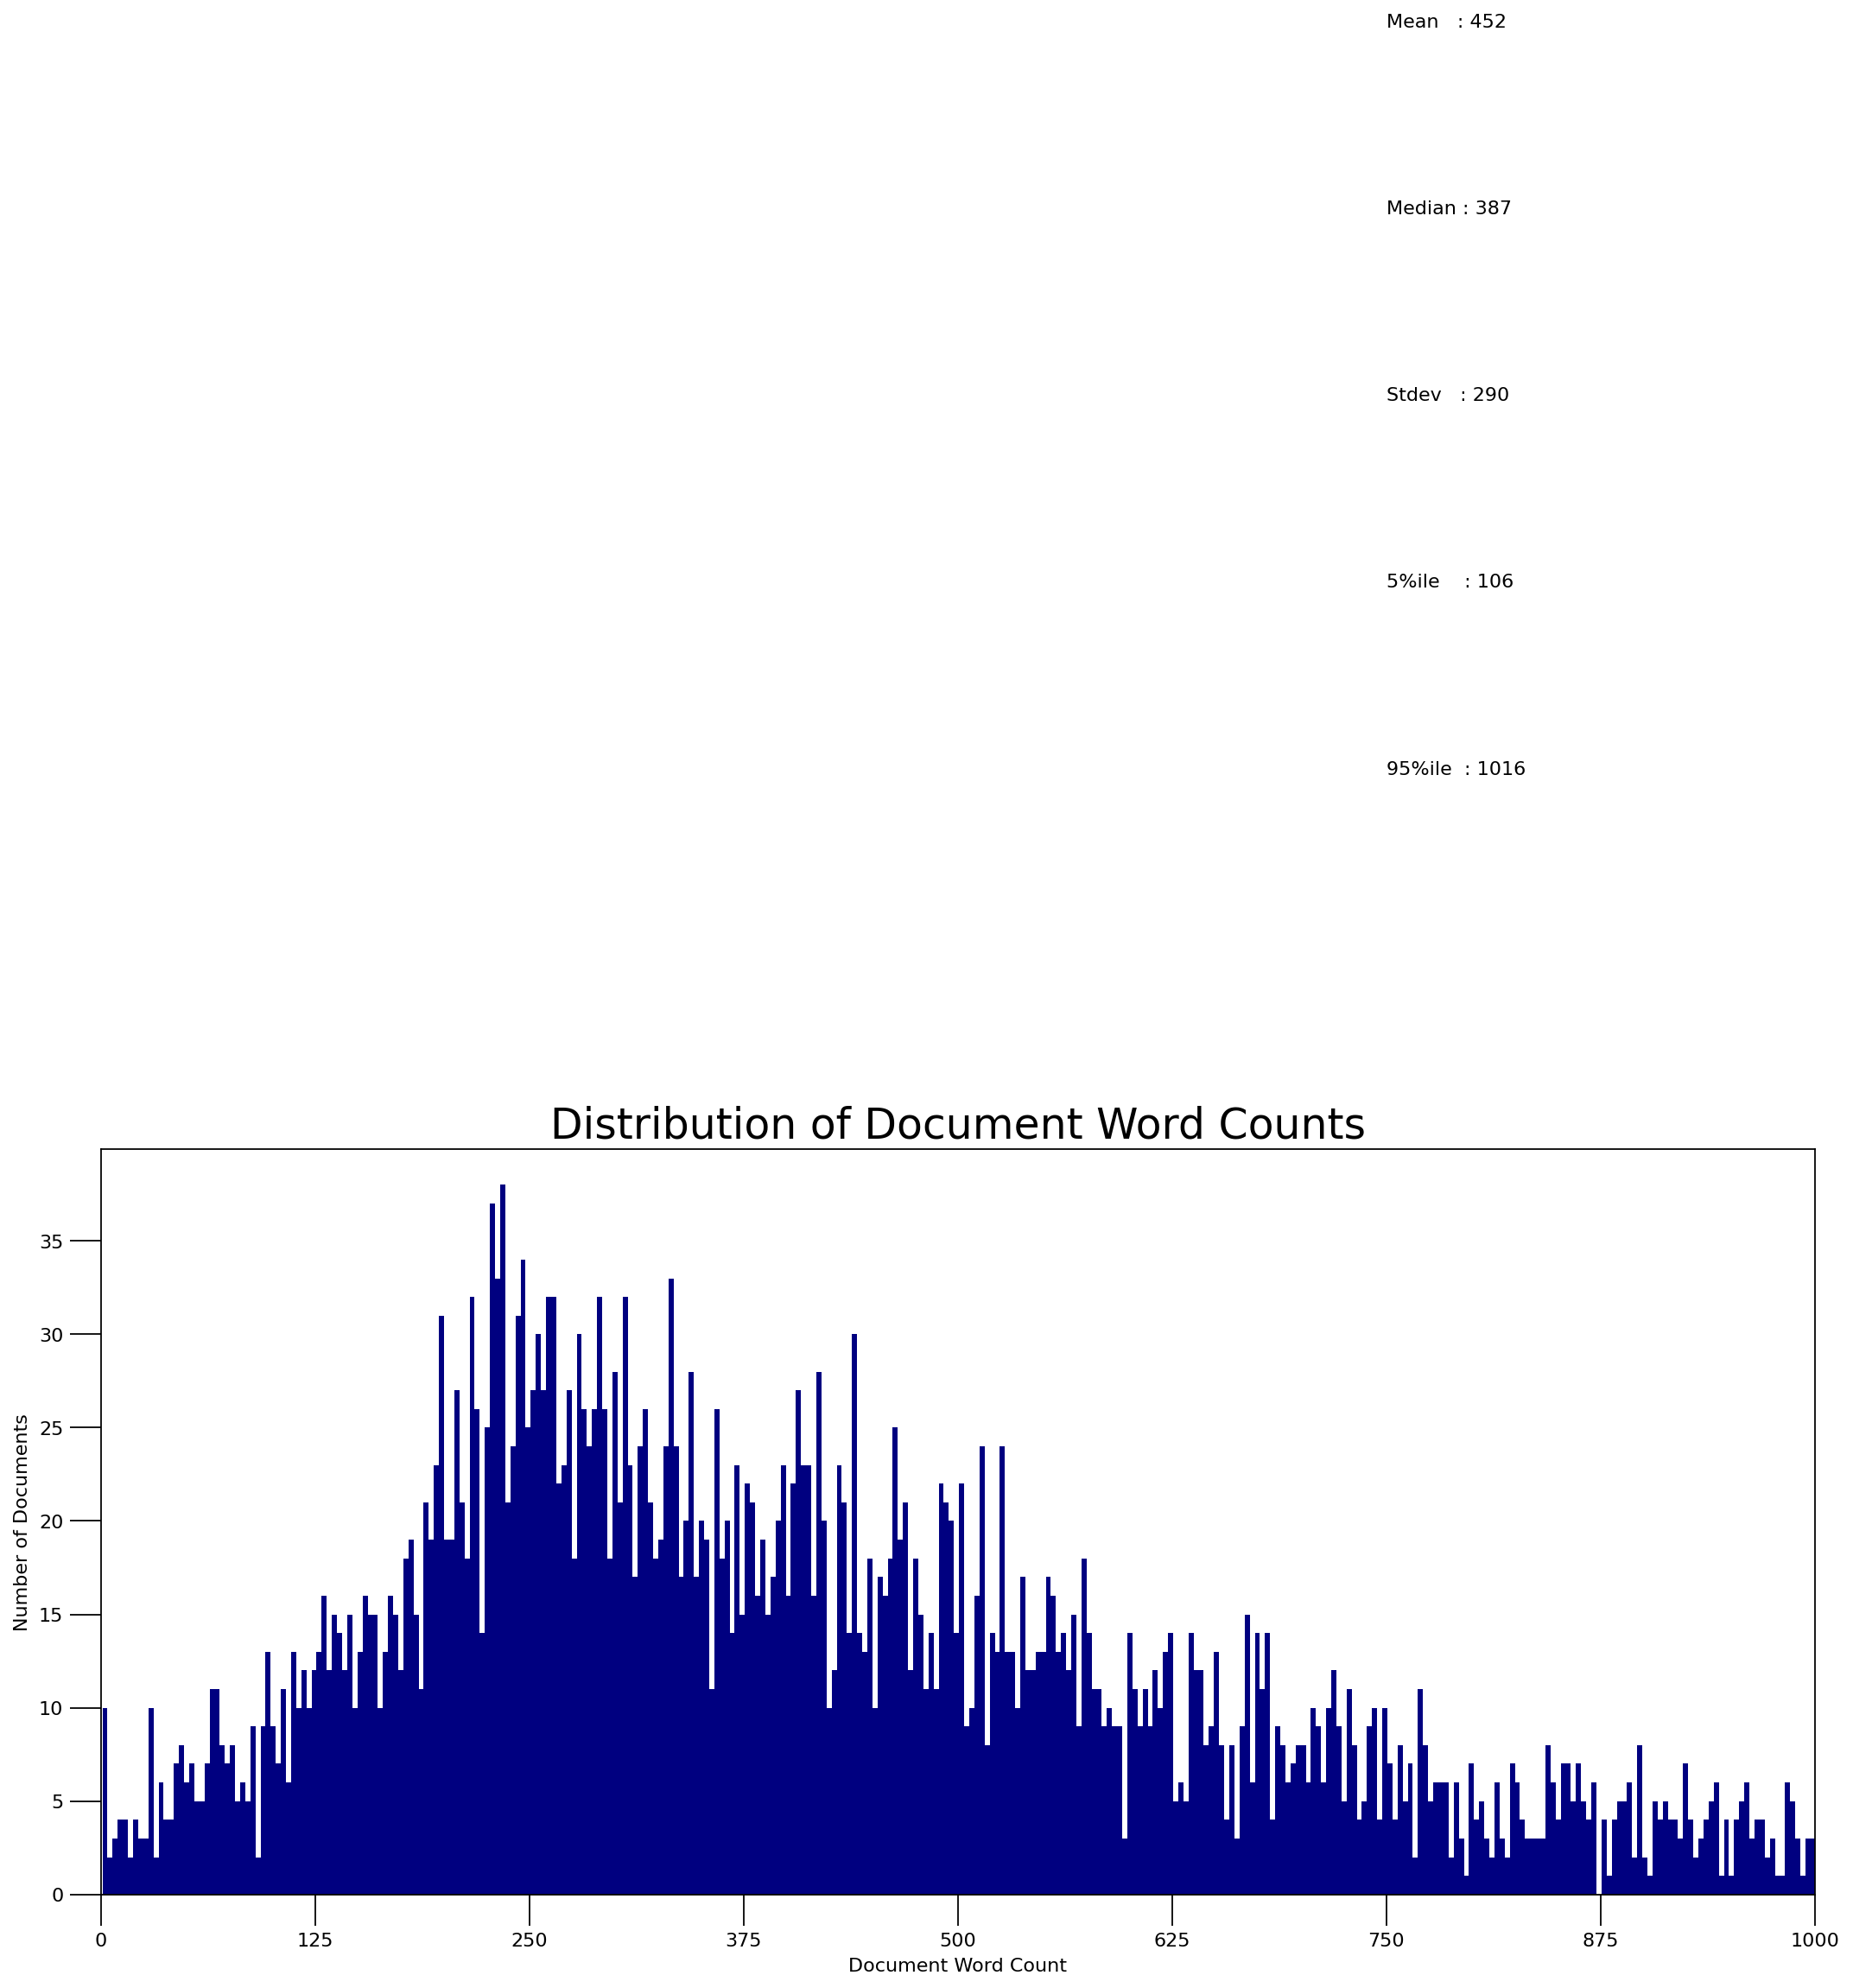

In [216]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "5%ile    : " + str(round(np.quantile(doc_lens, q=0.05))))
plt.text(750,  60, "95%ile  : " + str(round(np.quantile(doc_lens, q=0.95))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

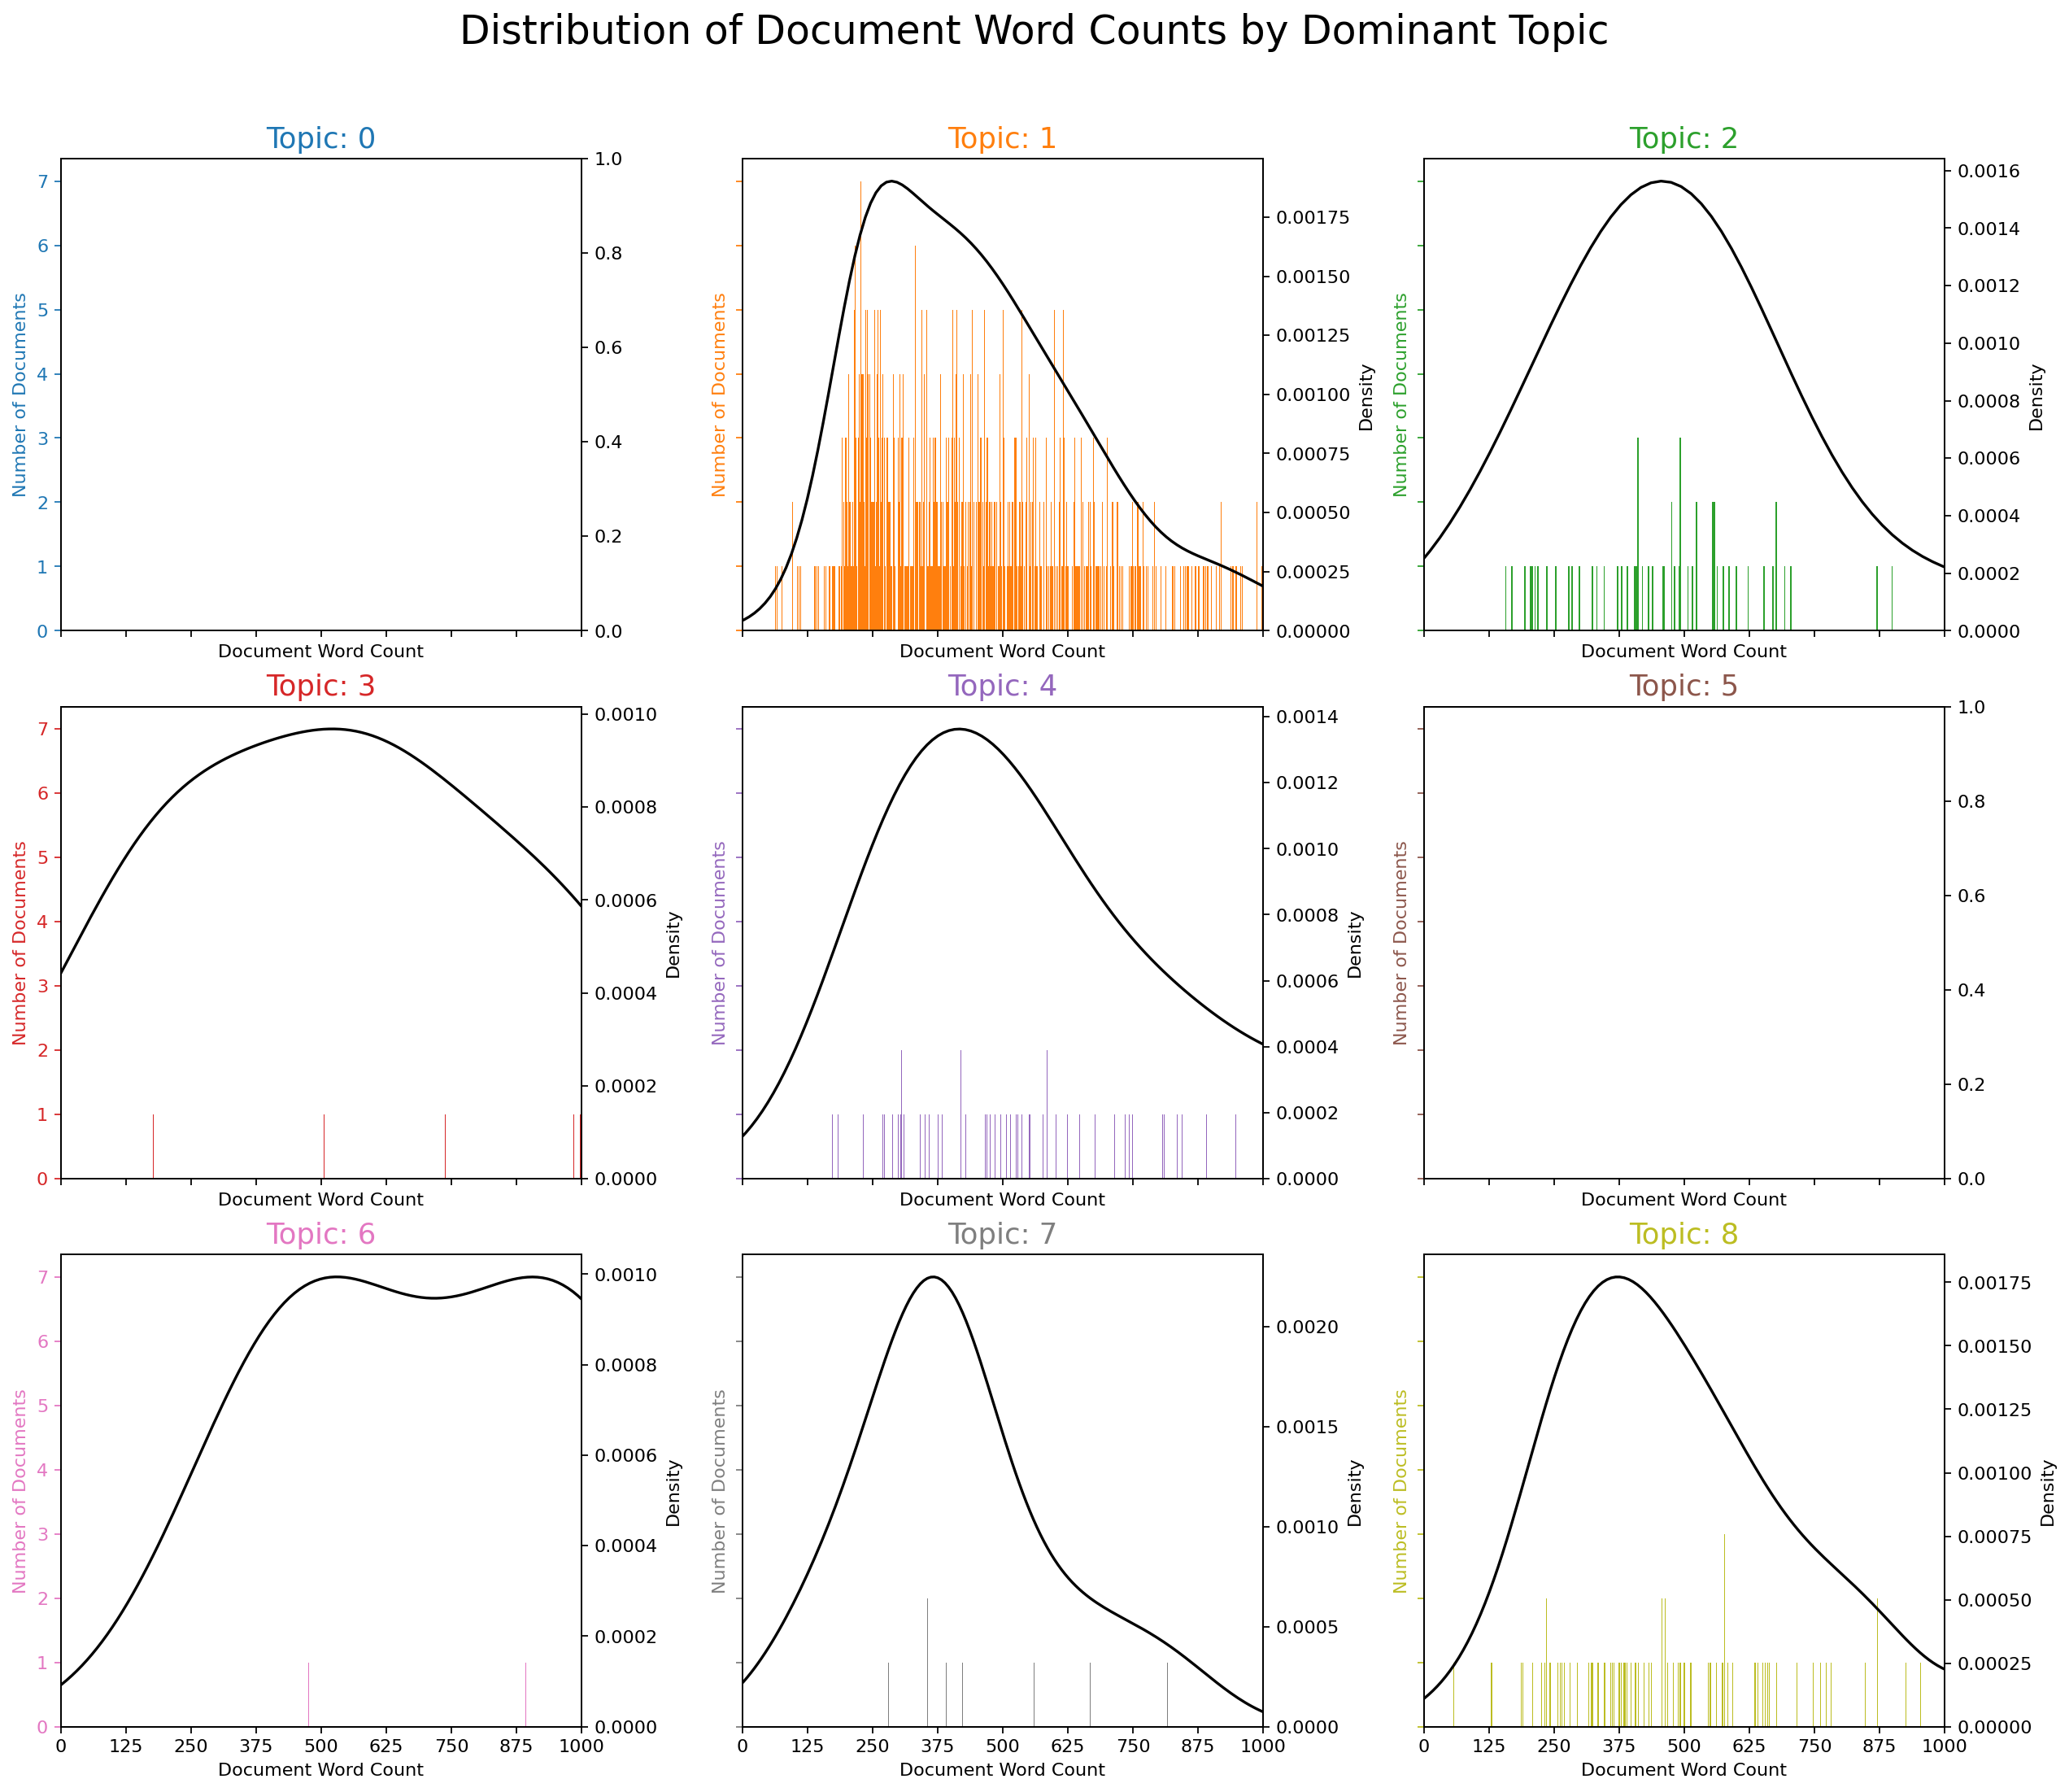

In [166]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

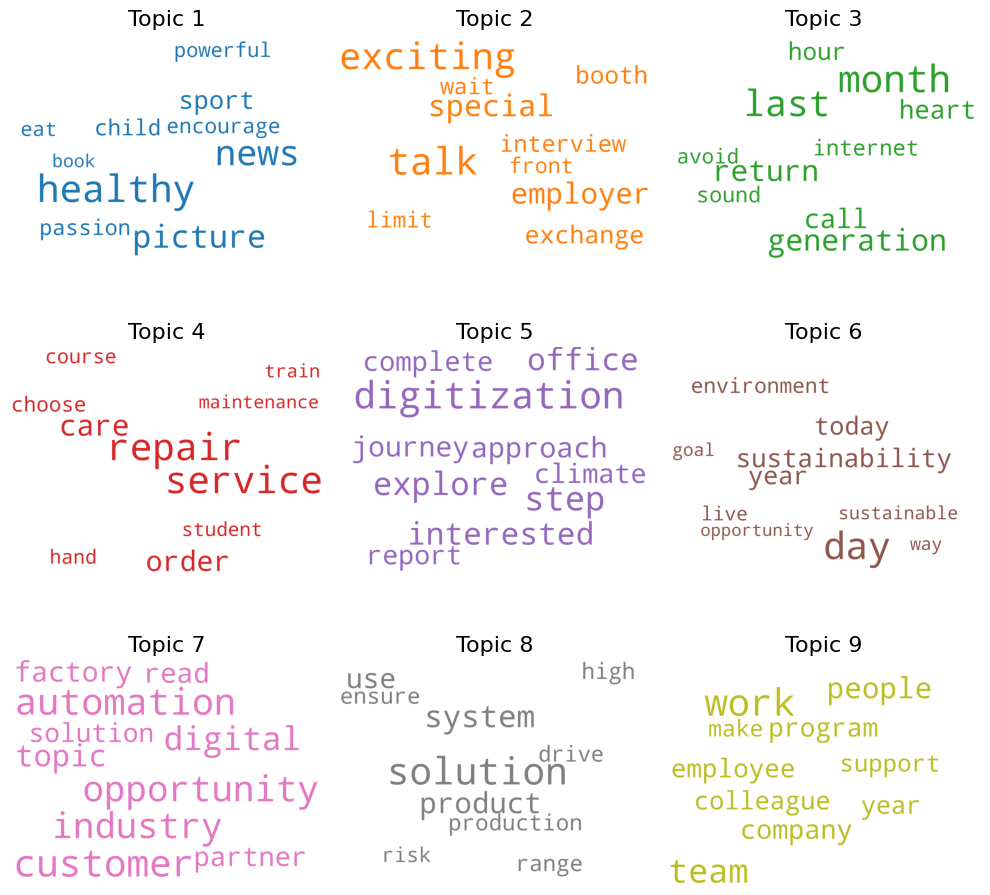

In [104]:
# 1. Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\vladi\AppData\Local\Temp\ipykernel_27792\855127490.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


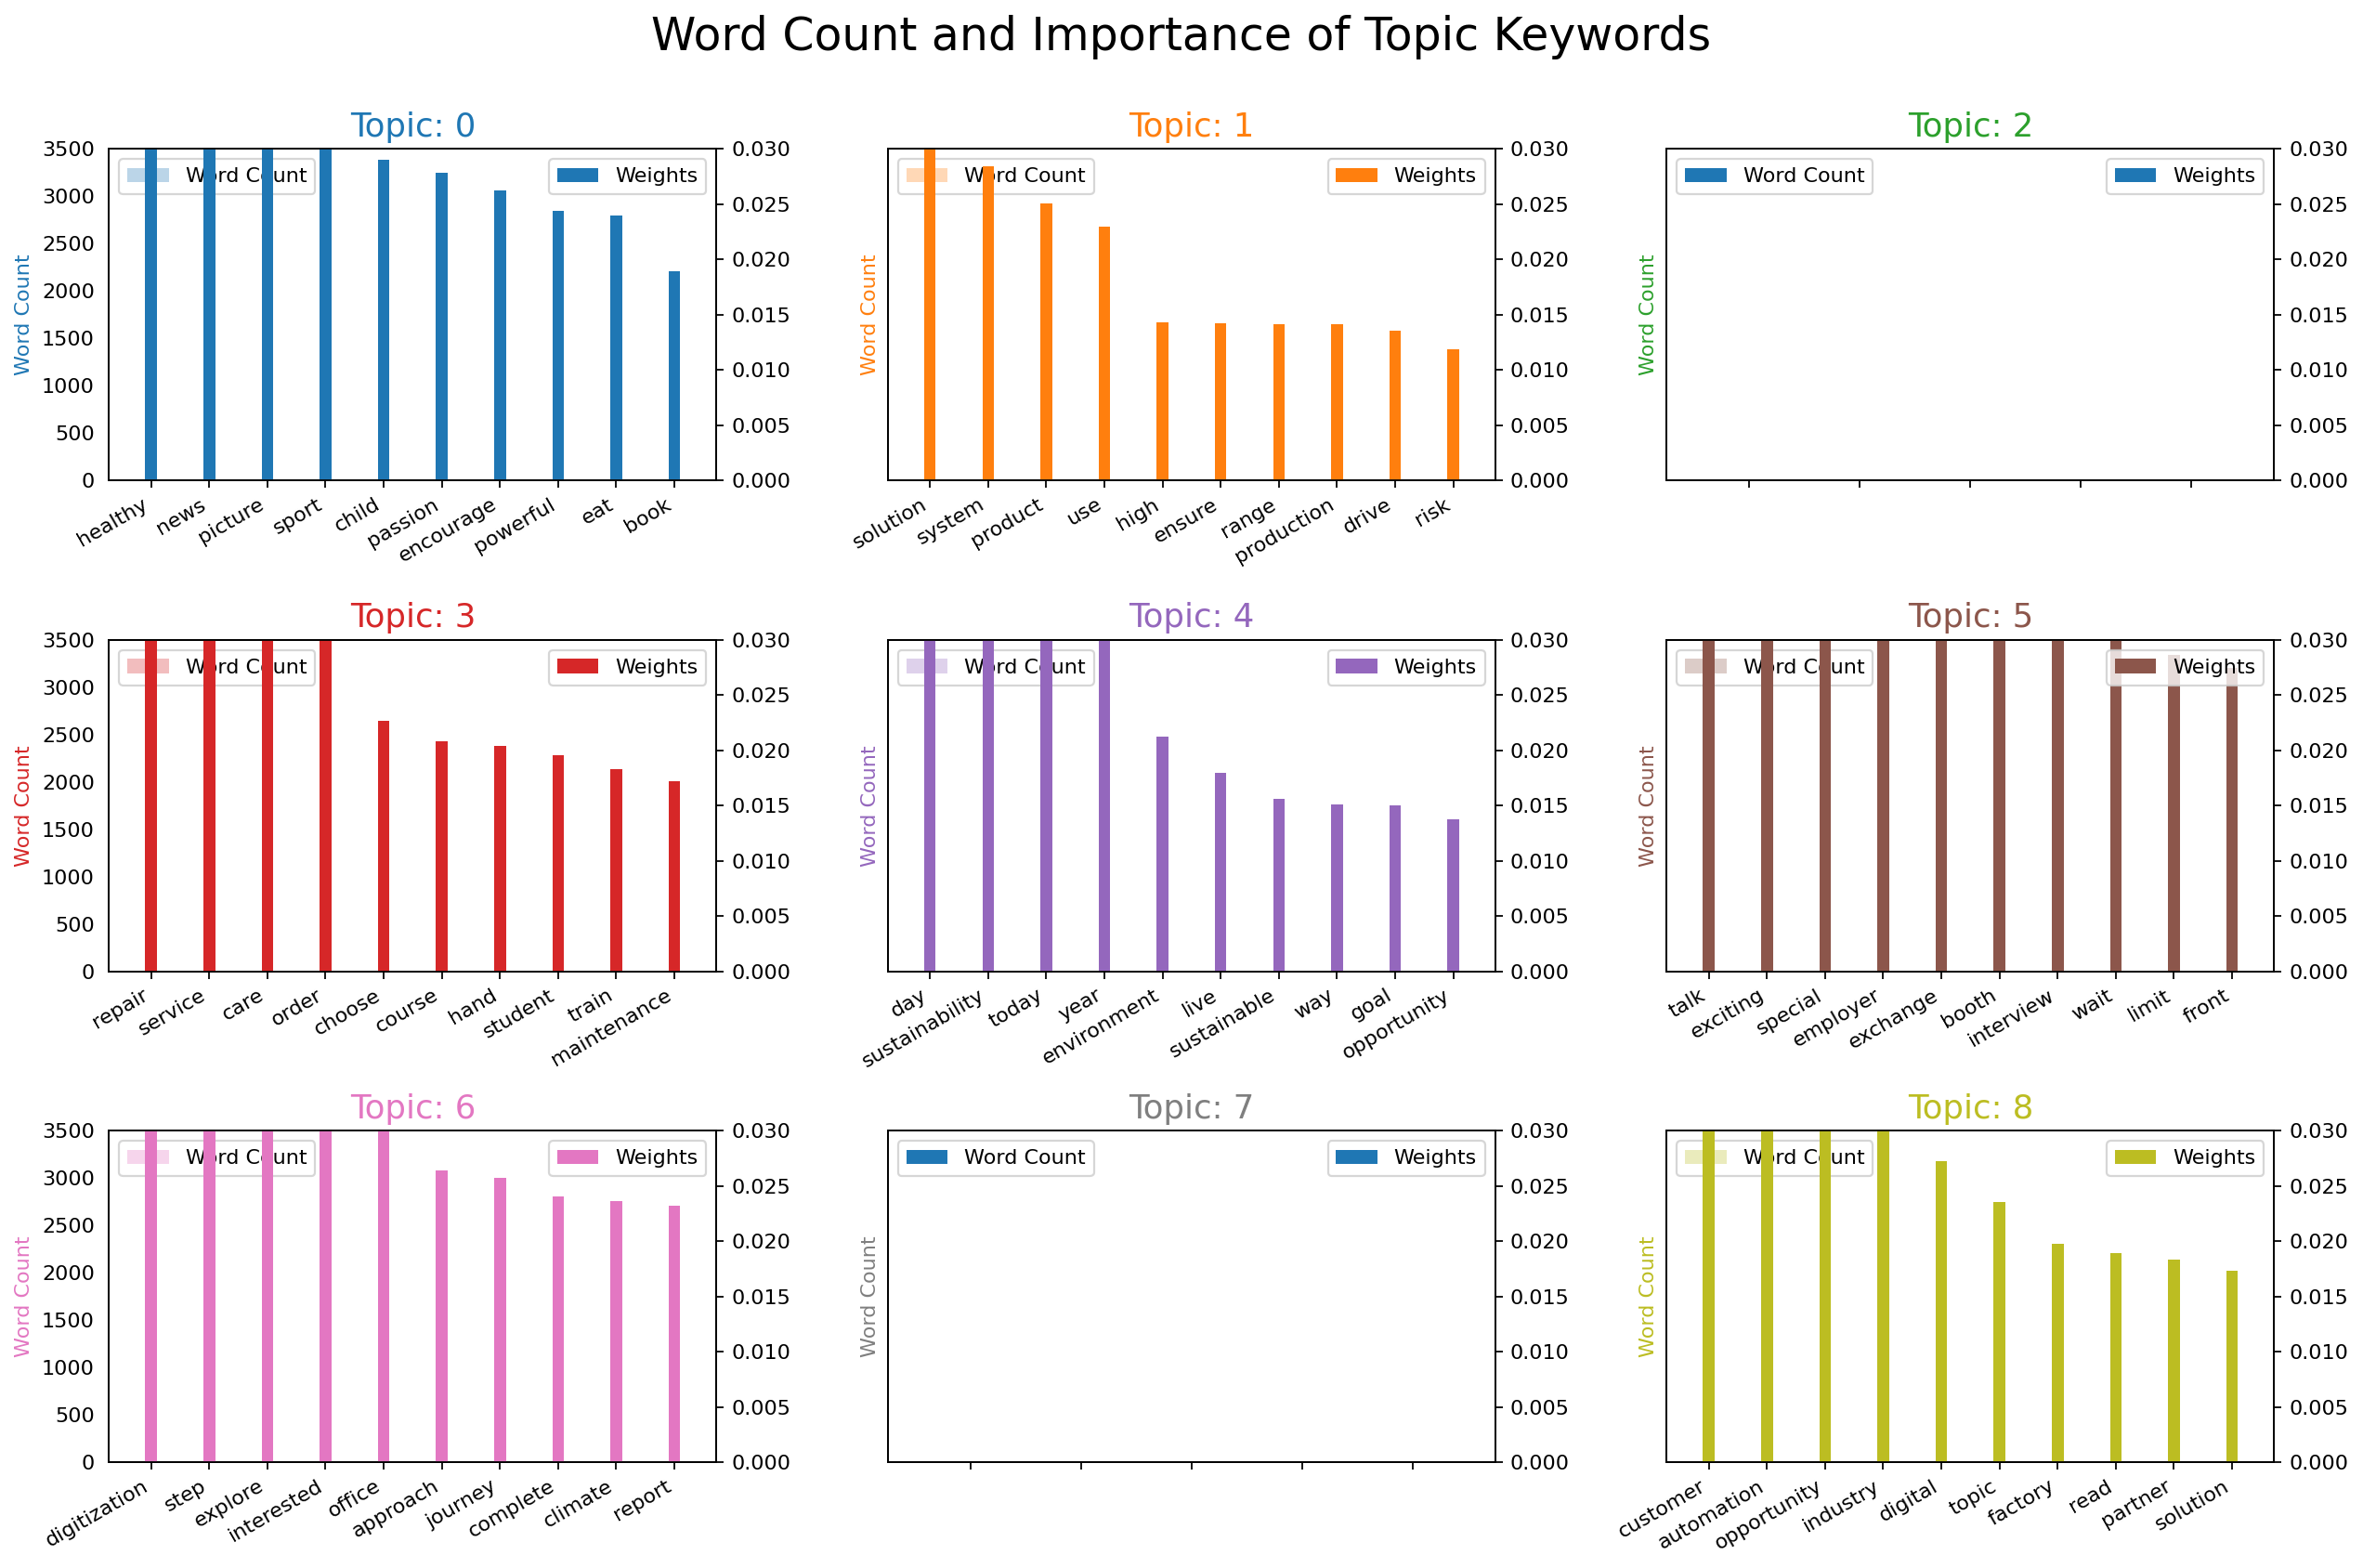

In [126]:
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

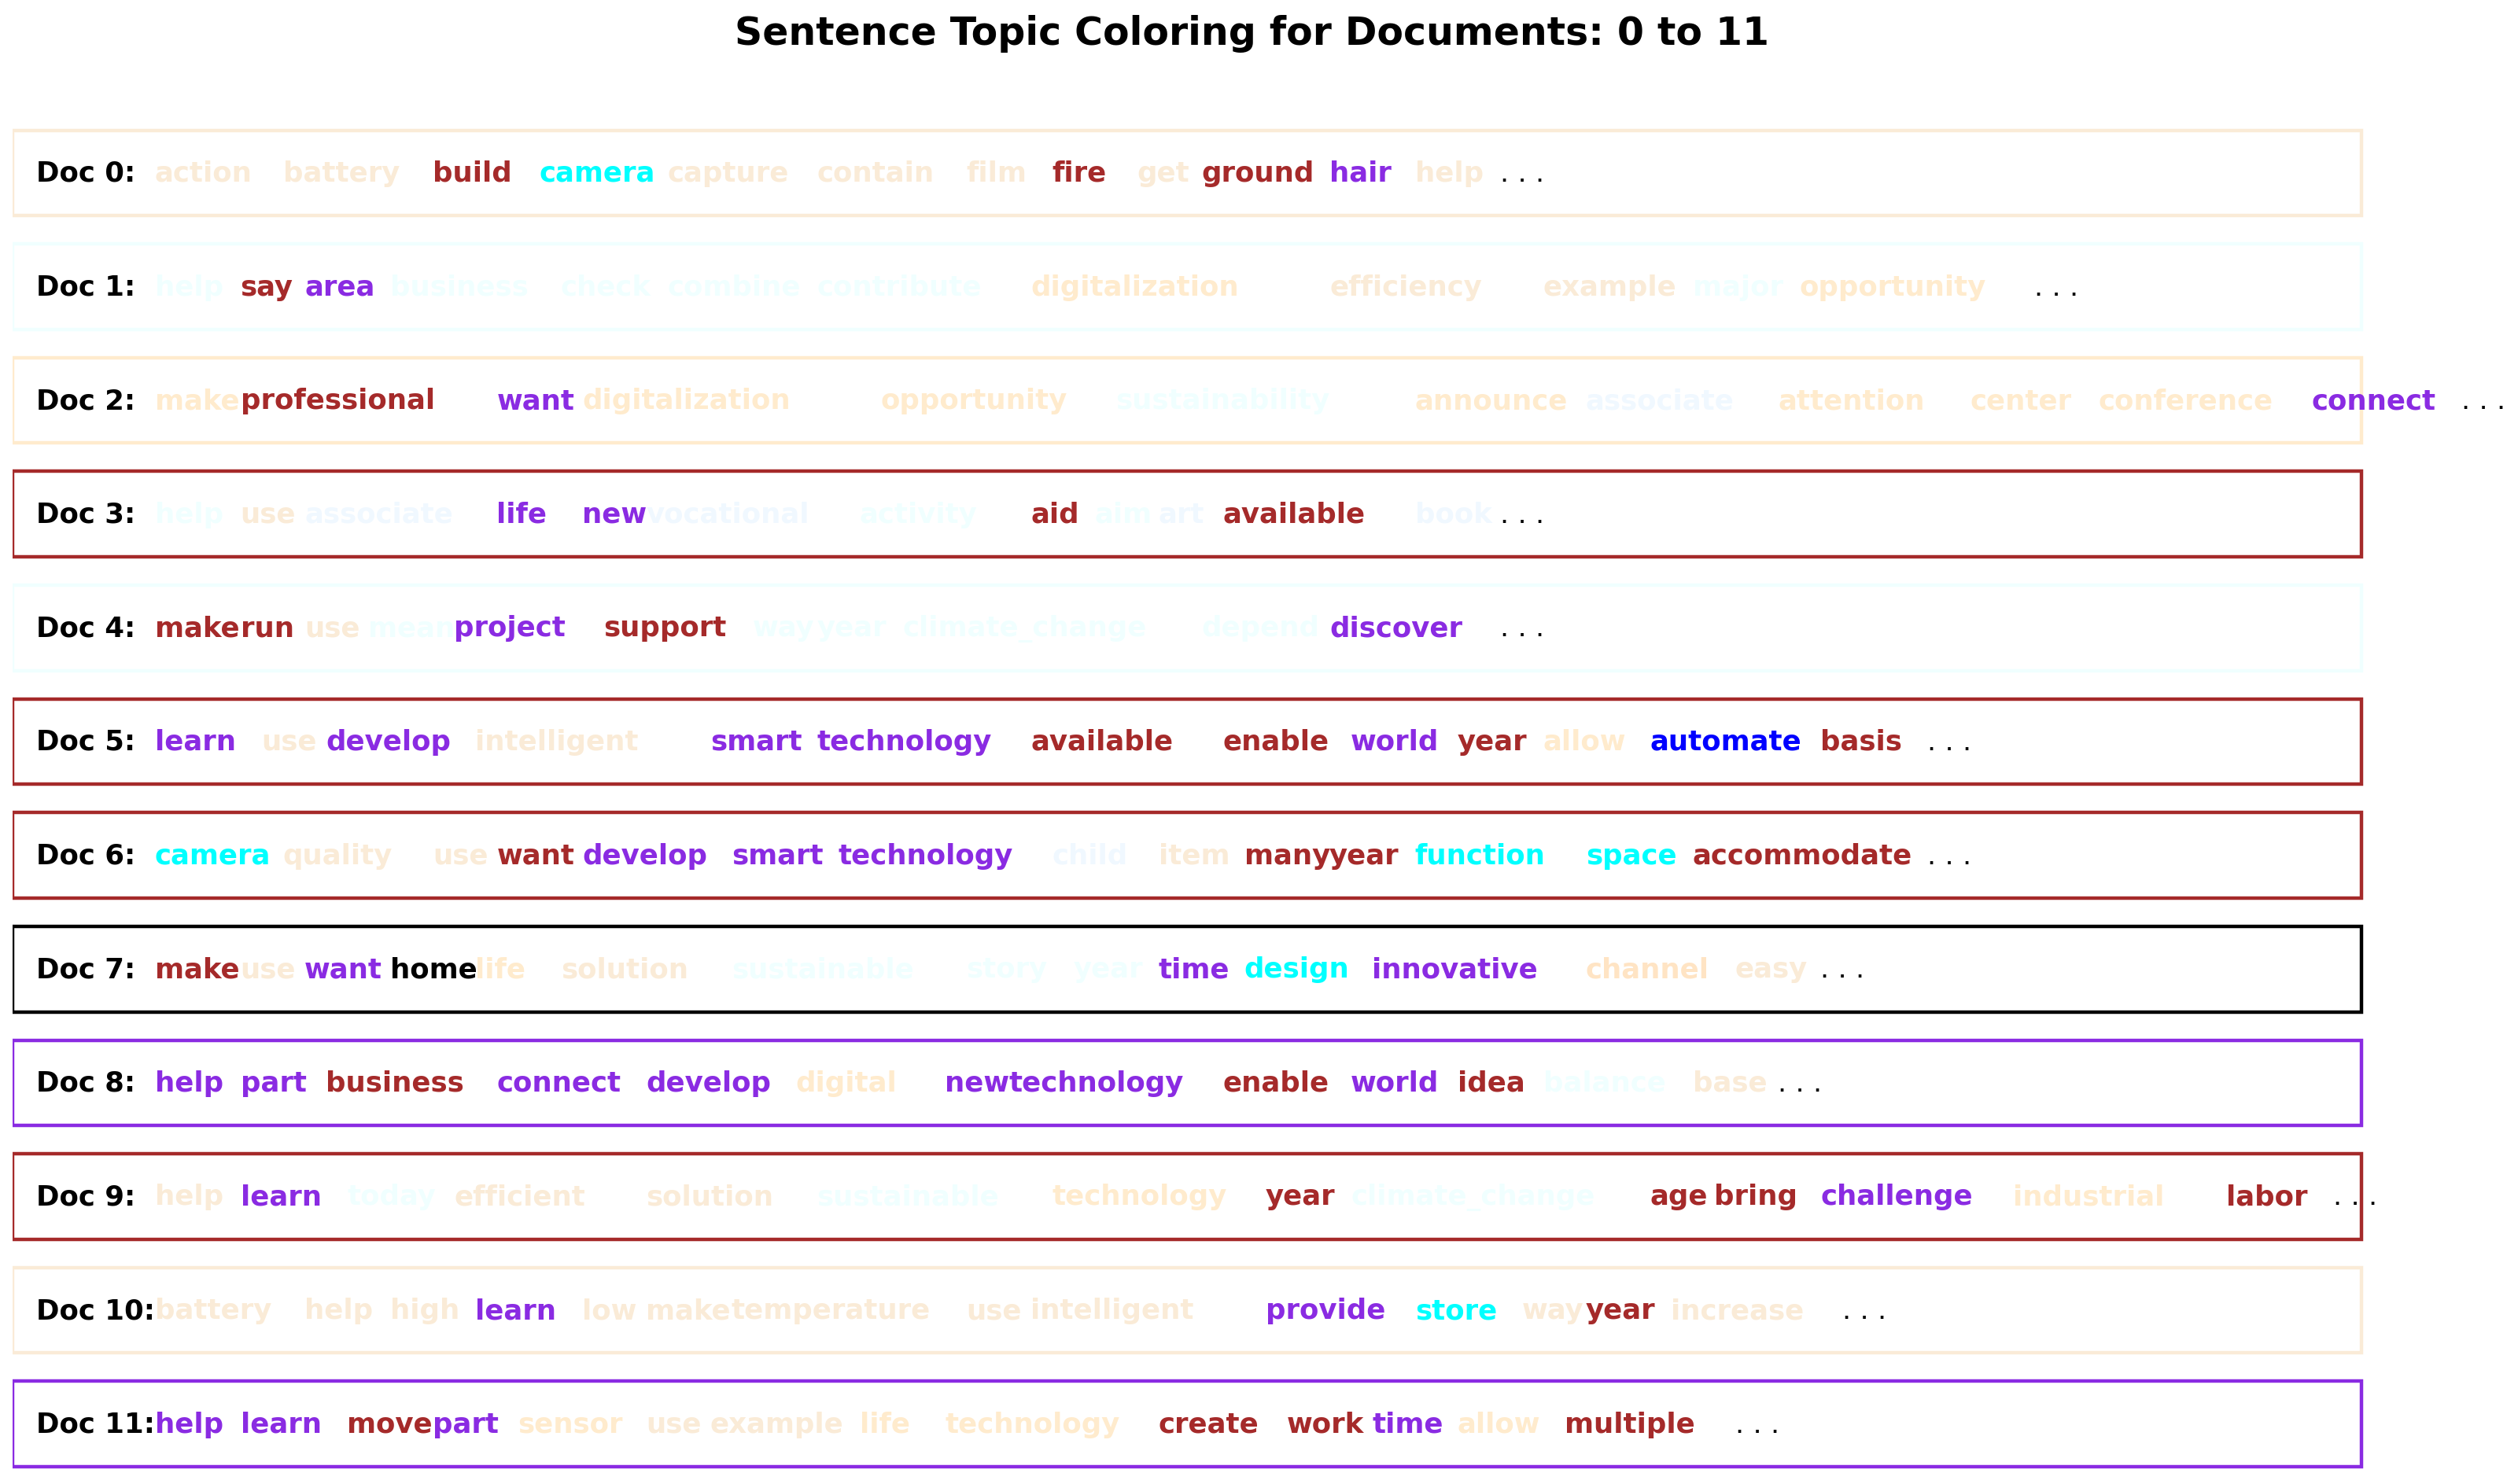

In [124]:
# Sentence Coloring of N Sentences
def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.CSS4_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14 and len(topics):
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics[0]],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model=optimal_model, corpus=corpus)

In [131]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

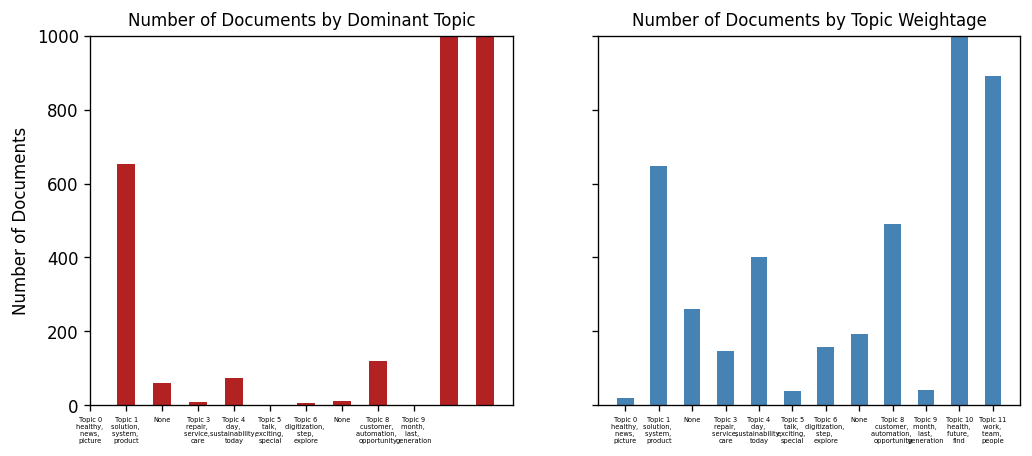

In [161]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0] if len(df_top3words.loc[df_top3words.topic_id==x, 'words'].values) else "None")
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.tick_params(axis='x', which='both', labelsize=4)
#plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.tick_params(axis='x', which='both', labelsize=4)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [112]:
# Get topic weights and dominant topics ------------

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    if isinstance(row_list[0], list):
        topic_weights.append([w for i, w in row_list[0]])
    else:
        topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 12
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.append(mycolors, "#569c98")
mycolors = np.append(mycolors, "#852ec0")
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 458 samples in 0.001s...
[t-SNE] Computed neighbors for 458 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 458 / 458
[t-SNE] Mean sigma: 0.071900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.334473
[t-SNE] KL divergence after 1000 iterations: 0.299699


Loading BokehJS ...